**Подключение библиотек и скриптов**

In [448]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [449]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [450]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [451]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
    def fit(self, df):
        """Сохранение статистик"""
        self.medians = df[['Square', 'LifeSquare', 'Rooms', 'HouseFloor']].median()

        self.DistrictId_value_counts = dict(df['DistrictId'].value_counts())
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df[['LifeSquare']] = df[['LifeSquare']].fillna(self.medians)
        
        # 2. Выбросы (outliers)
        
        # площадь < 10м2 заполняем средним значением
        df.loc[(df['Square'] > 300), 'Square'] = 300
        df.loc[(df['Square'] < 15), 'Square'] = 15
        
        # жилая площадь
        df.loc[(df['LifeSquare'] < 10), 'LifeSquare'] = 10
        df.loc[(df['LifeSquare'] > df['Square']*0.85), 'LifeSquare'] = df['Square']*0.85
        
        # 
        df.loc[(df['KitchenSquare'] < 3), 'KitchenSquare'] = 3
        df.loc[(df['KitchenSquare'] > df['Square']*0.3), 'KitchenSquare'] = df['Square']*0.3
        
        #
        df.loc[(df['HouseYear'] > 2020), 'HouseYear'] = datetime.datetime.now().year
        
        #
        df.loc[(df['Rooms'] > 6), 'Rooms'] = 6
        df.loc[(df['Rooms'] < 1), 'Rooms'] = 1
        
        #
        df.loc[(df['HouseFloor'] < 1), 'HouseFloor'] = 1
        
        #
        df.loc[(df['HouseFloor'] > 50), 'HouseFloor'] = self.medians['HouseFloor']
        
        # 4. Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        district_value_count = df['DistrictId'].map(self.DistrictId_value_counts)
        df = self.district_to_cat(df, district_value_count)
        df['district_cat'].fillna(5, inplace=True)
        
        df['DistrictId_counts'] = district_value_count
        df['DistrictId_counts'].fillna(501, inplace=True)
        
        df.drop('Healthcare_1', axis=1, inplace=True)
        
        return df
    
    @staticmethod
    def district_to_cat(df, district_value_count):
        
        df.loc[district_value_count <= 50, 'district_cat'] = 1
        df.loc[(district_value_count > 50) & (district_value_count <= 150), 'district_cat'] = 2
        df.loc[(district_value_count > 150) & (district_value_count <= 300), 'district_cat'] = 3
        df.loc[(district_value_count > 300) & (district_value_count <= 500), 'district_cat'] = 4
        df.loc[district_value_count > 500, 'district_cat'] = 5
            
        return df
    
    def transform_1(self, df):
        # 3. Новые фичи (features)
        
        #
        #df['SquareMeterPrice'] = df['Price'] / df['Square']
        
        #df['Price'] = df['Price'] // 10000 * 10000
        
        
        return df

In [452]:
DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREPARED_DATASET_PATH = 'train_prepared.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

In [453]:
pipe = DataPipeline()

df = pd.read_csv(DATASET_PATH)
df = reduce_mem_usage(df)

pipe.fit(df)
df = pipe.transform(df)

X_final = pd.read_csv(TEST_DATASET_PATH)
X_final = reduce_mem_usage(X_final)
X_final = pipe.transform(X_final)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [454]:
df.head().T

,0,1,2,3,4
Id,14038,15053,4765,5809,10783
DistrictId,35,41,53,58,99
Rooms,2,3,2,2,1
Square,47.9816,65.6836,44.948,53.353,39.6492
LifeSquare,29.4428,40.0495,29.1976,45.35,23.7762
KitchenSquare,6,8,3,9,7
Floor,7,7,8,8,11
HouseFloor,9,9,12,17,12
HouseYear,1969,1978,1968,1977,1976
Ecology_1,0.0890397,6.99893e-05,0.0496373,0.437885,0.0123389


In [455]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,16798.000000
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.889200,0.815592,1.000000,1.000000,2.000000,2.000000,6.000000
Square,10000.0,56.253937,19.576874,15.000000,41.774879,52.513309,65.900627,300.000000
LifeSquare,10000.0,34.474049,14.056864,10.000000,25.245647,32.781261,39.316624,255.000000
KitchenSquare,10000.0,6.445450,3.240418,3.000000,3.000000,6.000000,9.000000,41.721092
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,12.608700,6.532967,1.000000,9.000000,13.000000,17.000000,48.000000
HouseYear,10000.0,1984.872400,18.416347,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867


In [456]:
feature_names = ['district_cat', 'DistrictId_counts', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1',
                 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']

target_name = 'Price'

In [457]:
df = df[feature_names + [target_name]]
df.head().T

,0,1,2,3,4
district_cat,1.000000,2.000000,3.000000,3.000000,2.000000
DistrictId_counts,22.000000,87.000000,174.000000,179.000000,97.000000
Rooms,2.000000,3.000000,2.000000,2.000000,1.000000
Square,47.981560,65.683640,44.947952,53.352982,39.649193
LifeSquare,29.442751,40.049541,29.197611,45.350037,23.776169
KitchenSquare,6.000000,8.000000,3.000000,9.000000,7.000000
Floor,7.000000,7.000000,8.000000,8.000000,11.000000
HouseFloor,9.000000,9.000000,12.000000,17.000000,12.000000
HouseYear,1969.000000,1978.000000,1968.000000,1977.000000,1976.000000
Ecology_1,0.089040,0.000070,0.049637,0.437885,0.012339


In [458]:
X_final = X_final[feature_names + ['Id']]
X_final.head().T

,0,1,2,3,4
district_cat,3.000000,2.000000,1.00,2.000000,5.000000
DistrictId_counts,179.000000,114.000000,7.00,97.000000,851.000000
Rooms,2.000000,2.000000,1.00,2.000000,1.000000
Square,49.882645,69.263184,15.00,73.046608,47.527111
LifeSquare,33.432781,32.781261,12.75,51.940842,40.398045
KitchenSquare,6.000000,3.000000,4.50,9.000000,3.000000
Floor,6.000000,6.000000,2.00,22.000000,17.000000
HouseFloor,14.000000,1.000000,5.00,22.000000,17.000000
HouseYear,1972.000000,1977.000000,1909.00,2007.000000,2017.000000
Ecology_1,0.310199,0.075779,0.00,0.101872,0.072158


In [391]:
feature_names_for_stand = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [316]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min)
# StandardScaler() Для каждой фичи х делает: (x - mean) / std
# RobustScaler() Для каждой фичи х делает: (x - median) / (q75 - q25)

scaler = StandardScaler()
stand_features_0 = scaler.fit_transform(df[feature_names_for_stand])
stand_features_1 = scaler.fit_transform(X_final[feature_names_for_stand])

In [317]:
df[feature_names_for_stand] = pd.DataFrame(stand_features_0, columns=feature_names_for_stand)
df.head().T

,0,1,2,3,4
DistrictId,-0.353348,-0.215687,0.059635,0.174352,1.115034
Rooms,0.136936,1.368379,0.136936,0.136936,-1.094506
Square,-0.400058,0.443745,-0.544661,-0.144019,-0.797236
LifeSquare,-0.391927,0.245940,-0.406670,1.008604,-0.732702
KitchenSquare,-0.395661,0.723606,-0.395661,1.283240,0.163973
Floor,-0.291306,-0.291306,-0.100498,-0.100498,0.471924
HouseFloor,-0.552411,-0.552411,-0.093178,0.672209,-0.093178
HouseYear,-0.861908,-0.373187,-0.916210,-0.427489,-0.481792
Ecology_1,-0.250529,-0.998053,-0.581588,2.680470,-0.894969
Social_1,0.474169,1.215681,0.531208,-0.096225,0.588247


In [459]:
#X_final[feature_names_for_stand] = pd.DataFrame(stand_features_1, columns=feature_names_for_stand)
X_final[X_final['DistrictId_counts'].isna()]

,district_cat,DistrictId_counts,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Id


In [460]:
X = df[feature_names]
y = df[target_name]

In [461]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [462]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')

In [463]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [464]:
%%time
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42
                         )
params = {'n_estimators':[50, 100, 200, 300, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=42, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 2min 19s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [465]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [466]:
gs.best_score_

0.7383346068085247

R2:	0.841
RMSE:	37102.114
MSE:	1376566885.252


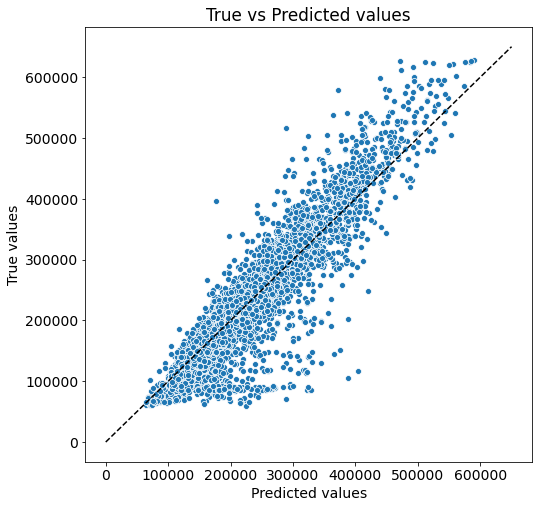

In [467]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=10,
                                        random_state=42,  
                                        n_estimators=100)

final_model.fit(X_train, y_train)

y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.726
RMSE:	48573.874
MSE:	2359421269.331


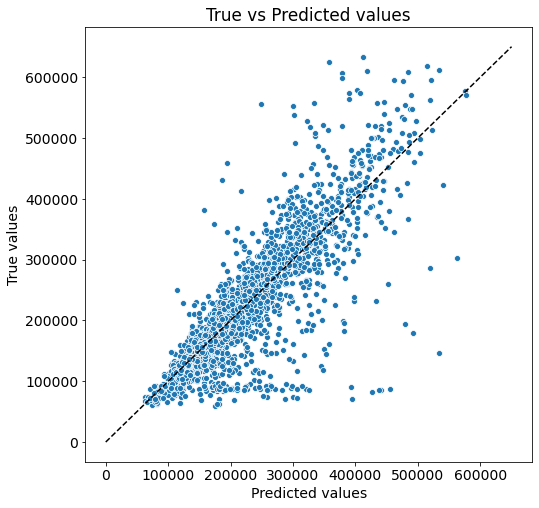

In [468]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=False)

In [469]:
final_model.feature_importances_

array([3.80696157e-04, 2.63028011e-01, 2.20513055e-02, 4.80503996e-01,
       1.48538459e-02, 1.24753797e-02, 1.37001376e-02, 1.32401982e-02,
       2.61286501e-02, 3.58138502e-02, 1.94474509e-02, 2.91911702e-02,
       5.82965351e-02, 3.87386348e-03, 5.89747619e-03, 3.51198640e-05,
       9.82343166e-05, 2.81496254e-04, 5.98408234e-04, 1.04175505e-04,
       0.00000000e+00])

In [470]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [471]:
feature_importances.head(50)

,feature_name,importance
3,Square,0.480504
1,DistrictId_counts,0.263028
12,Social_3,0.058297
9,Ecology_1,0.035814
11,Social_2,0.029191
8,HouseYear,0.026129
2,Rooms,0.022051
10,Social_1,0.019447
4,LifeSquare,0.014854
6,Floor,0.013700


In [170]:
feature_importances.tail(5)

,feature_name,importance
17,Ecology_3_A,0.000244
16,Ecology_2_B,0.000170
19,Shops_2_A,0.000122
15,Ecology_2_A,0.000086
20,Shops_2_B,0.000000


In [171]:
feature_final = feature_importances.loc[feature_importances['importance'] > 0.01]

In [ ]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [472]:
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X_final.set_index('Id', inplace=True)
X_final = X_final[feature_names]

In [473]:
X_final.T

Id,725,15856,5480,15664,14275,7633,13329,5502,4220,11538,...,15706,2105,7220,14562,6836,8180,4695,5783,4780,12504
district_cat,3.000000,2.000000,1.00,2.000000,5.000000,3.000000,5.000000,1.000000,2.000000,5.000000,...,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,5.000000,2.000000,3.000000,3.000000
DistrictId_counts,179.000000,114.000000,7.00,97.000000,851.000000,174.000000,565.000000,34.000000,71.000000,511.000000,...,89.000000,28.000000,71.000000,41.000000,57.000000,129.000000,652.000000,64.000000,247.000000,228.000000
Rooms,2.000000,2.000000,1.00,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,...,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,3.000000,2.000000,2.000000
Square,49.882645,69.263184,15.00,73.046608,47.527111,40.675625,68.099541,48.193897,72.277107,80.219398,...,47.776485,45.493240,80.182495,46.627884,45.131283,67.133911,40.198471,77.842178,81.305222,60.555695
LifeSquare,33.432781,32.781261,12.75,51.940842,40.398045,32.781261,57.884613,32.857643,45.968758,47.660259,...,27.920874,32.022564,48.627327,27.058739,30.780550,50.809795,21.807060,48.282623,32.781261,32.781261
KitchenSquare,6.000000,3.000000,4.50,9.000000,3.000000,3.000000,3.000000,6.000000,9.000000,9.000000,...,6.000000,6.000000,10.000000,5.000000,6.000000,6.000000,10.000000,9.000000,3.000000,3.000000
Floor,6.000000,6.000000,2.00,22.000000,17.000000,21.000000,2.000000,5.000000,17.000000,13.000000,...,8.000000,4.000000,10.000000,6.000000,2.000000,5.000000,12.000000,23.000000,4.000000,10.000000
HouseFloor,14.000000,1.000000,5.00,22.000000,17.000000,21.000000,17.000000,14.000000,17.000000,17.000000,...,9.000000,9.000000,17.000000,5.000000,5.000000,9.000000,17.000000,22.000000,1.000000,17.000000
HouseYear,1972.000000,1977.000000,1909.00,2007.000000,2017.000000,1977.000000,1977.000000,1972.000000,1997.000000,2014.000000,...,1970.000000,1974.000000,2003.000000,1969.000000,1965.000000,1973.000000,2017.000000,1989.000000,1977.000000,1977.000000
Ecology_1,0.310199,0.075779,0.00,0.101872,0.072158,0.049637,0.075779,0.135650,0.041116,0.243205,...,0.282798,0.135650,0.041116,0.307467,0.428826,0.000170,0.007122,0.090799,0.072158,0.000078


In [474]:
y_pred_final = final_model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False, encoding='utf-8', sep=',')

preds_final.head()

,Id,Price
0,725,159401.298614
1,15856,242942.578312
2,5480,218479.302843
3,15664,333975.240547
4,14275,141645.939387
